## 설명
- 하나의 시퀀스를 다른 시퀀스로 바꾸는 2개의 RNN 이 동시 동작하는 s2s 네트워크
- encoder network : 입력 시퀀스를 벡터로 압축
- decoder network : 압축된 벡터를 새로운 시퀀스로 펼침



In [10]:
from __future__ import unicode_literals, print_function, division
from io import open 
import unicodedata
import string
import re
import tqdm
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- 문자 단위 RNN 튜토리언 내 문자 인코딩과 유사하게, 언어의 각 단어를 one-hot 벡터로 표현
- 나중에 네트워크 입력 및 목표로 사용하기 위해서는 단어당 고유 번호가 필요
- word2index, index2word 사전을 준비
- 희귀 단어를 대체하는 데 사용할, 각 단어 빈도를 가진 클래스도 사용 예정

In [11]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"}
    self.n_words = 2 #SOS, EOS 모두 포함

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else :
      self.word2count[word] += 1


In [12]:
# 유니코드 문자열을 일반 ascii 로 변환
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )

def normalizeString(s):
  s  = unicodeToAscii(s.lower().strip()) #소문자 다듬고 합치고
  s = re.sub(r"([.!?])", r" \1", s) # 문자가 아닌 문자들 제거
  s = re.sub(r"[^a-zA-z.!?]+", r" ", s)# 아닌 것들 공백으로 변경
  return s
  

In [13]:
def readLangs(lang1, lang2, reverse = False):
  print("Reading lines...")
  # 파일을 읽고 줄로 분리 
  lines = open('/content/drive/My Drive/korean_embedding/raw_data/data/data/%s-%s.txt' % (lang1, lang2), encoding = 'utf-8'). \
  read().strip().split('\n')

  # 모든줄을 쌍으로 분리하고 정규화
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
  
  #쌍을 뒤집고 lang 인스턴스 생성
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
  else:
    input_lang = Lang(lang1)
    ouput_lang = Lnag(lang2)
  return input_lang, output_lang, pairs


In [14]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
  return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]


데이터 준비
- 텍스트 파일을 읽음
- 줄로 분리
- 줄을 쌍으로 분리
- 텍스트 정규화 하고 길이와 내용으로 필터링
- 쌍을 이룬 문장들로 단어 리스트 생성

In [15]:
def prepareData(lang1, lang2, reverse = False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  print('Read %s sentence pairs' % len(pairs))
  pairs = filterPairs(pairs)
  print('Trimmed to %s sentence pairs' % len(pairs))
  print('Counting words...')
  for pair in pairs : 
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted words: ")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words: 
fra 4345
eng 2803
['elle ne m est pas etrangere .', 'she is no stranger to me .']


## Seq2Se2 모델
- 인코더 : 프랑스어 문장을 RNN 사용하여 읽어들여 단일 벡터를 출력
  - 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN
  - 모든 입력 단어에 대해 벡터 & 은닉상태 출력
  - 이때의 은닉상태는 다음 단어에 적용

- 디코더 : 해당 벡터를 받아 번역을 생성하기 위한 단어 시퀀스를 출력
  - 인코더의 마지막 출력만 이용 : 문맥벡터가 전체 시퀀스의 문맥을 인코딩
  - 디코더의 초기 은닉 상태로 사용
  - 매 단계에서 input, prev_hidden 이 주어짐
  - 초기 토큰은 start-of-string SOS 이 주어짐

In [16]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1) # 인풋값을 임베딩하고 
    output = embedded
    output, hidden = self.gru(output, hidden)  #그것을 gru gated united recurrent
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device = device)
    

In [17]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, input, hidden):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, deivce = device)
    

## Attention 디코더
- 문맥 벡터만 인코더-디코더로 전달된다면? 단일 벡터가 전체 문장을 인코딩 해야 하는 상황
- Attention 은 디코더 네트워크가 자기 출력의 모든 단계에서, 인코더 출력의 다른 부분에 attention 할 수 있게 함
  1. attention 가중치 세트를 계산 
   -  가중치 조합을 만들기 위해 인코더 출력 벡터와 곱해짐
   - attn_applied 는 입력 시퀀스 특정 부분에 관한 정보를 포함하여, 디코더가 알맞은 출력 단어를 선택하고도록 함
   - 이 계산은 디코더의 입력 및 은닉 상태를 입력으로 사용하는 다른 feed-forward 계층인 attn 으로 수행
   - 이 계층은 실제 문장 길이를 사용하지 않고, 인코더 출력을 위한 최대 문장 길이를 선택

   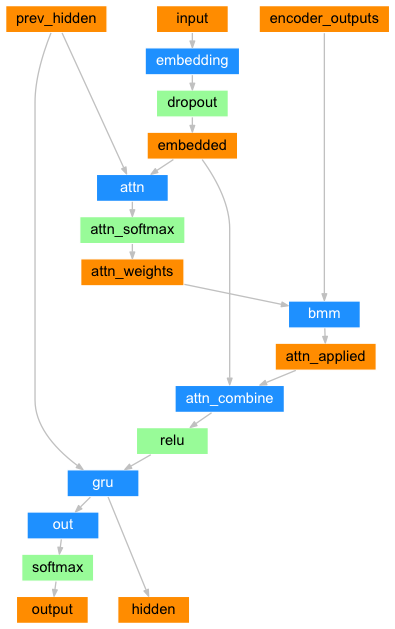

In [82]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p = 0.1, max_length=MAX_LENGTH):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length

    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size * 2, self.max_length) # 왜 여기서 hidden_size 2배, max_length 만큼 만들까?
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, 1, -1) 
    embedded = self.dropout(embedded)

    attn_weights = F.softmax( 
        self.attn(
            torch.cat((embedded[0], hidden[0]), 1)) # 임베딩과 히든 레이어를 concat 해준뒤
        , dim = 1) # 그 다음 attn 의 소프트맥스를 취한 결과물을 attn_weight 에 담아둔다
    attn_applied = torch.bmm(attn_weights.unsqueeze(0), 
                             # torch.bmm batch matrix multiplication 을 수행하는 함수 
                             # 2개 이상의 차원을 지닌 텐서가 주어졌을 떄 뒤의 2개 차원에 대해 행렬 곱을 수행하고, 앞의 다른 차원은 미니배치로 취급
                             # (batch_size, n, k) x (batch_size, k, m) = (batch_size, n, m)
                             encoder_outputs.unsqueeze(0))
    
    output = torch.cat((embedded[0], attn_applied[0]), 1) # 아까 만들어둔 embedded 와 attn_applied 를 합쳐본다
    output = self.attn_combine(output).unsqueeze(0) # attn_combine 한다

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    
    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights
  
  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device= device)

## 학습
- 학습을 위해 각 쌍마다 input Tensor 와 target Tensor 필요
- 두 시퀀스에 EOS 토큰 추가

In [83]:
def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')] # 문장을 인덱스로 변환

def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token) # EOS 토큰 추가
  return torch.tensor(indexes, dtype = torch.long, device = device).view(-1, 1) # 텐서로 변환하고 .view(-1, 1) 사용해서 열로 변환 

def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(input_lang, pair[0])
  target_tensor = tensorFromSentence(output_lang, pair[1])
  return (input_tensor, target_tensor)

## 모델 학습 
- 인코더에 입력 문장을 넣음 -> 모든 output 과 최신 hidden 레이어를 받음
- 디코더에 <SOS> 토큰과 최신 hidden 상태를 넣음

- "Teach forcing" 은 다음 입력으로 디코더의 예측을 사용하는 대신, 실제 목표 출력을 다음 입력으로 사용하는 컨셉 
  - 빠른 수렴이 가능하나, 학습된 네트워크가 잘못 사용될 떄 불안정함
  - 해당 네트워크는 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다
- autograd 덕분에 if 문으로 teacher forcing 사용 여부 선택도 가능하며, 비율도 조절 가능하다 
  - teacher_forcing_ratio 


In [84]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
  encoder_hidden = encoder.initHidden()

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

  loss = 0

  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei] , encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

  decoder_input = torch.tensor([[SOS_token]], device = device)
  decoder_hidden = encoder_hidden
  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing :
    # teacher_forcing 포함할 경우 : 목표를 다음 입력으로 전달
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[di])
      decoder_input = target_tensor[di]

  else :
    # teacher forcing 미포함 : 자신의 예측을 다음 입력으로 사용
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
          decoder_input, decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach() # 입력으로 사용할 부분을 히스토리에서 분리

      loss += criterion(decoder_output, target_tensor[di])
      if decoder_input.item() == EOS_token:
        break
    
  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length


In [85]:
import  time
import math

def asMinutes(s):
  m = math.floor(s / 60)
  s -= m*60
  return '%dm %ds' % (m, s)

def timeSince(since, percent):
  now = time.time()
  s = now - since
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

남은 전체 학습 과정
- 타이머 시작
- optimizers 와 criterion 초기화
- 학습 쌍의 세트 생성
- 도식화를 위한 빈 손실 배열 시작 --> ??

### train 을 여러번 호출하여, 떄로는 진행률( 예제의 %, 현재까지의 예상 시간) 과 평균 손실을 출력

In [86]:
def trainIters(encoder, decoder, n_iters, print_every = 1000, plot_every =100, learning_rate = 0.01):
  start = time.time()
  plot_losses = []
  print_loss_total  = 0 #print_every 마다 초기화 ## 왜 그때마다 초기화를 하려고 할ㄲ?
  plot_loss_total = 0 # plot_every 마다 초기화

  encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
  training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
  criterion = nn.NLLLoss()

  for iter in range(1, n_iters +1):
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss
    
    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print("%s (%d %d%% %.4f" % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_Total = 0
  
  showPlot(plot_losses)

## 결과 도식화
- matplotlib 로 학습 중에 저장된 손실 값plot_losses 의 배열을 사용하여 도식화

In [87]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()

  # 주기적인 간격에 이 locator 가 tick 을 설정
  loc = ticker.MultipleLocator(base = 0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(polints)

## 평가
- target 없이 진행:  각 단계의 디코더의 예측을 되돌려 전달함
- 단어를 예측할때마다 그 단어를 문자열에 추가
- EOS 토큰을 예측할 시, 거기서 그 단어를 멈춤
- 이후 도식화를 위해 디코더의 attention 출력을 저장

In [88]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_lang, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)

    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device = device) #SOS
    decoder_hidden = encoder_hidden
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      decoder_attentions[di] = decoder_attention.data
      topv, topi = decoder_output.data.topk(1)
      if topi.item() == EOS_token:
        decoded_words.append('<EOS>')
        break
      else:
        decoded_words.append(output_lang.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()

  return deocded_words, decoder_attentions[:di + 1]

In [89]:
# 임의로 품질 판단도 가능함
def evaluateRandomly(encoder, deocder, n = 10):
  for i in range(n):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print(' ')

In [90]:
hidden_size = 265
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p = 0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every = 5000)

5m 38s (- 78m 54s) (5000 6% 2.8426
11m 25s (- 74m 17s) (10000 13% 2.2609
17m 19s (- 69m 18s) (15000 20% 1.9869
23m 7s (- 63m 35s) (20000 26% 1.6891
29m 5s (- 58m 10s) (25000 33% 1.5333
35m 14s (- 52m 51s) (30000 40% 1.3596
41m 24s (- 47m 19s) (35000 46% 1.2405
47m 31s (- 41m 35s) (40000 53% 1.1020
53m 32s (- 35m 41s) (45000 60% 0.9803
59m 31s (- 29m 45s) (50000 66% 0.8861
65m 48s (- 23m 55s) (55000 73% 0.8077
72m 3s (- 18m 0s) (60000 80% 0.7542
78m 10s (- 12m 1s) (65000 86% 0.6678
84m 15s (- 6m 1s) (70000 93% 0.6068
90m 19s (- 0m 0s) (75000 100% 0.5464


NameError: ignored

In [91]:
evaluateRandomly(encoder1, attn_decoder1)

> il est capitaine de l equipe .
= he is the captain of the team .


NameError: ignored

## attention 시각화
- attention 메커니즘은 해석 가능성이 높은 output 을가지고 있음
- input sequence 의 특정 encoder output 에 가중치를 부여하는데 사용되어, 각 시점에 네트워크가 가장 집중되는 위치를 파악 가능
- attention output 을 matrix 로 표시하기 위해 plt.matshow(attentions) 실행 가능

In [92]:
output_words, attentions = evaluate( encoder1, attn_decoder1, 'je suis trop froid .')
plt.matshow(attentions.numpy())
# 열은 입력, 행은 출력단계

NameError: ignored

In [ ]:
def showAttention(input_sentence, output_words, attentions):
  # colorbar 로 그림설정
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.mat

  